<a href="https://colab.research.google.com/github/dgambone3/CSC6740_Data_Mining_Project/blob/main/Data_Mining_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.utils import resample
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [31]:
data = pd.read_csv('/content/drive/MyDrive/DM_Project/fetal_health.csv')
feat = data[['baseline value', 
              'accelerations', 
              'fetal_movement',
              'uterine_contractions', 
              'light_decelerations', 
              'severe_decelerations',
              'prolongued_decelerations', 
              'abnormal_short_term_variability',
              'mean_value_of_short_term_variability',
              'mean_value_of_long_term_variability',
              'percentage_of_time_with_abnormal_long_term_variability',
              'fetal_health']]
feat = feat.rename(columns={'percentage_of_time_with_abnormal_long_term_variability':'percent_time_abnormal_long_variability'})
data.shape

(2126, 22)

In [32]:
X = feat[['baseline value', 
          'accelerations', 
          'fetal_movement',
          'uterine_contractions', 
          'light_decelerations', 
          'severe_decelerations',
          'prolongued_decelerations', 
          'abnormal_short_term_variability',
          'mean_value_of_short_term_variability',
          'mean_value_of_long_term_variability',
          'percent_time_abnormal_long_variability']]
y = feat[['fetal_health']]

In [ ]:
feat.describe().T

In [ ]:
feat.info()

In [35]:
# Scale data with standard scalar
sc = StandardScaler().set_output(transform='pandas')
scaled = sc.fit(X).transform(X)

In [36]:
pca = PCA()
pca.fit(scaled)
d = {'Feature':scaled.columns.values, 'PCA Variance Ratio':pca.explained_variance_ratio_}
pca_info = pd.DataFrame(data=d)
l=[]

for z in range(1, len(pca_info['PCA Variance Ratio']) + 1):
  l.append(sum(pca_info['PCA Variance Ratio'].iloc[:z]))

pca_info['Sum PCA Variance'] = l
display(pca_info)

,Feature,PCA Variance Ratio,Sum PCA Variance
0,baseline value,0.250640,0.250640
1,accelerations,0.148219,0.398859
2,fetal_movement,0.107775,0.506633
3,uterine_contractions,0.102701,0.609334
4,light_decelerations,0.089323,0.698657
5,severe_decelerations,0.076052,0.774709
6,prolongued_decelerations,0.066112,0.840821
7,abnormal_short_term_variability,0.059541,0.900362
8,mean_value_of_short_term_variability,0.043945,0.944307
9,mean_value_of_long_term_variability,0.036622,0.980929


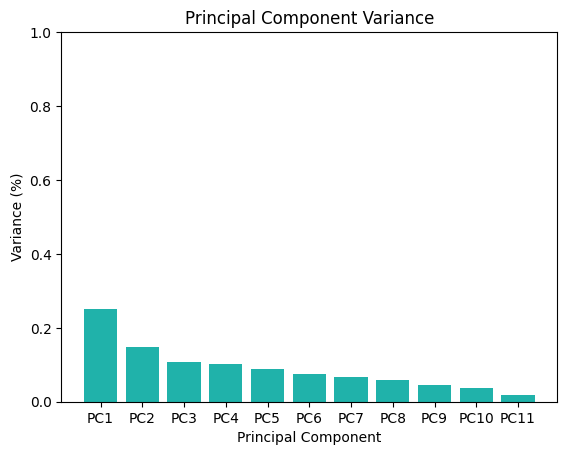

In [37]:
trained_pca = pca.transform(scaled)
var_ratio = pca_info['PCA Variance Ratio']

x=range(0, len(var_ratio))
plt.bar(x, var_ratio, color='lightseagreen')
plt.ylabel('Variance (%)')
plt.xlabel('Principal Component')
plt.xticks(x, ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11'])
plt.ylim([0,1])
plt.title('Principal Component Variance')
plt.show()

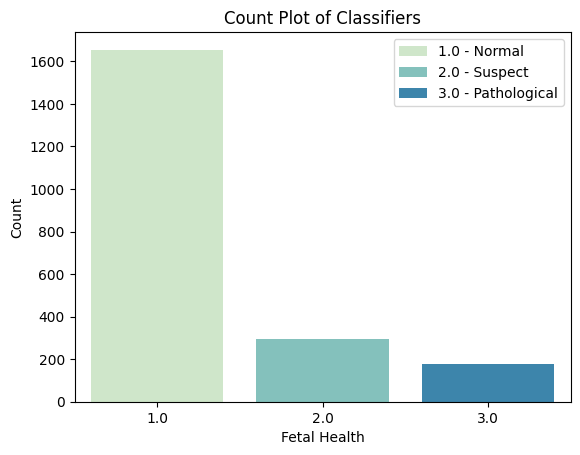

In [38]:
labels = ['1.0 - Normal', '2.0 - Suspect', '3.0 - Pathological']
sns.countplot(data, x='fetal_health', palette='GnBu', label=labels)
plt.title('Count Plot of Classifiers')
plt.xlabel('Fetal Health')
plt.ylabel('Count')
plt.legend()
plt.show()

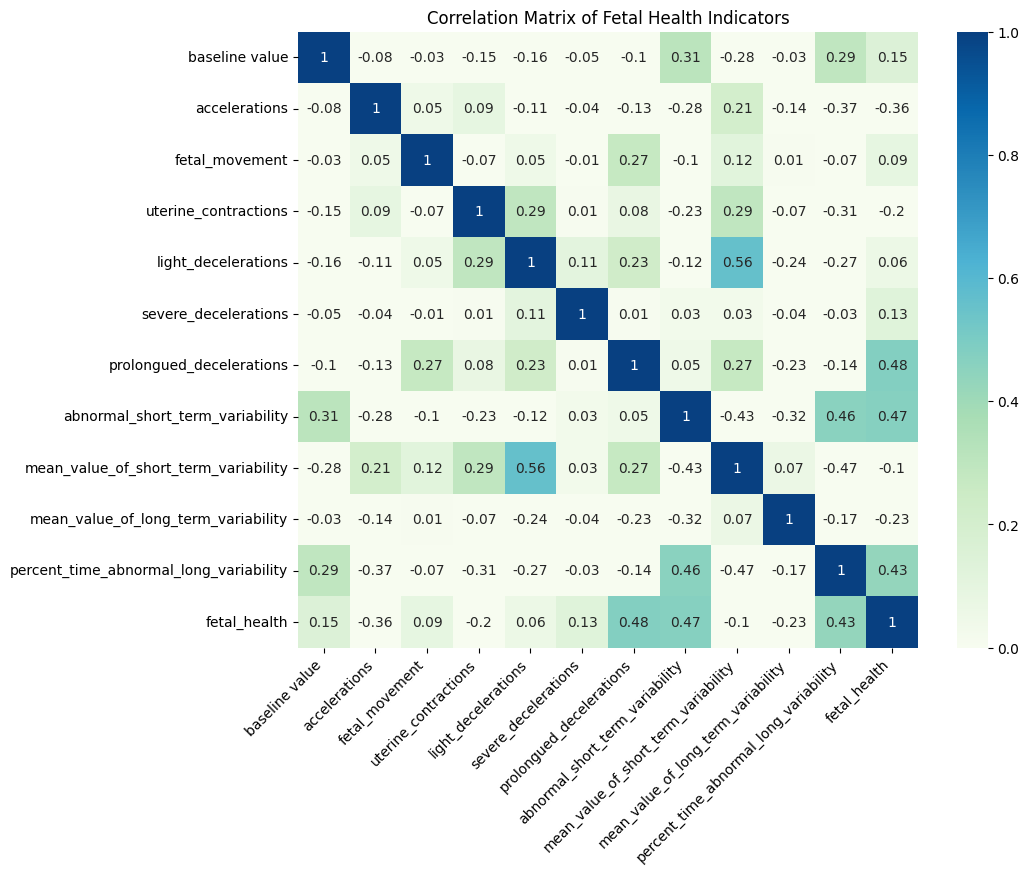

In [39]:
corr = round(feat.corr(), 2)
fig = plt.figure(figsize=(10,8))
axes = fig.subplots()

sns.heatmap(corr, vmin=0, vmax=1, annot=True, cmap='GnBu')

plt.title('Correlation Matrix of Fetal Health Indicators')
plt.xticks(ha='right', rotation=45)
plt.show()

In [ ]:
fig = plt.figure(figsize=(20,15))
axes = fig.subplots(3,4)
i = 0
j = 0
for col in feat[:-2]:
  sns.boxplot(x=feat['fetal_health'], 
              y = feat[col], 
              data=feat, 
              ax=axes[i,j], 
              palette='GnBu')
  axes[i,j].set_title(f'{col} Box Plot')
  i+=1
  j+=1
  if j == 4: j=0
  if i == 3: i=0
fig.tight_layout()
plt.show()

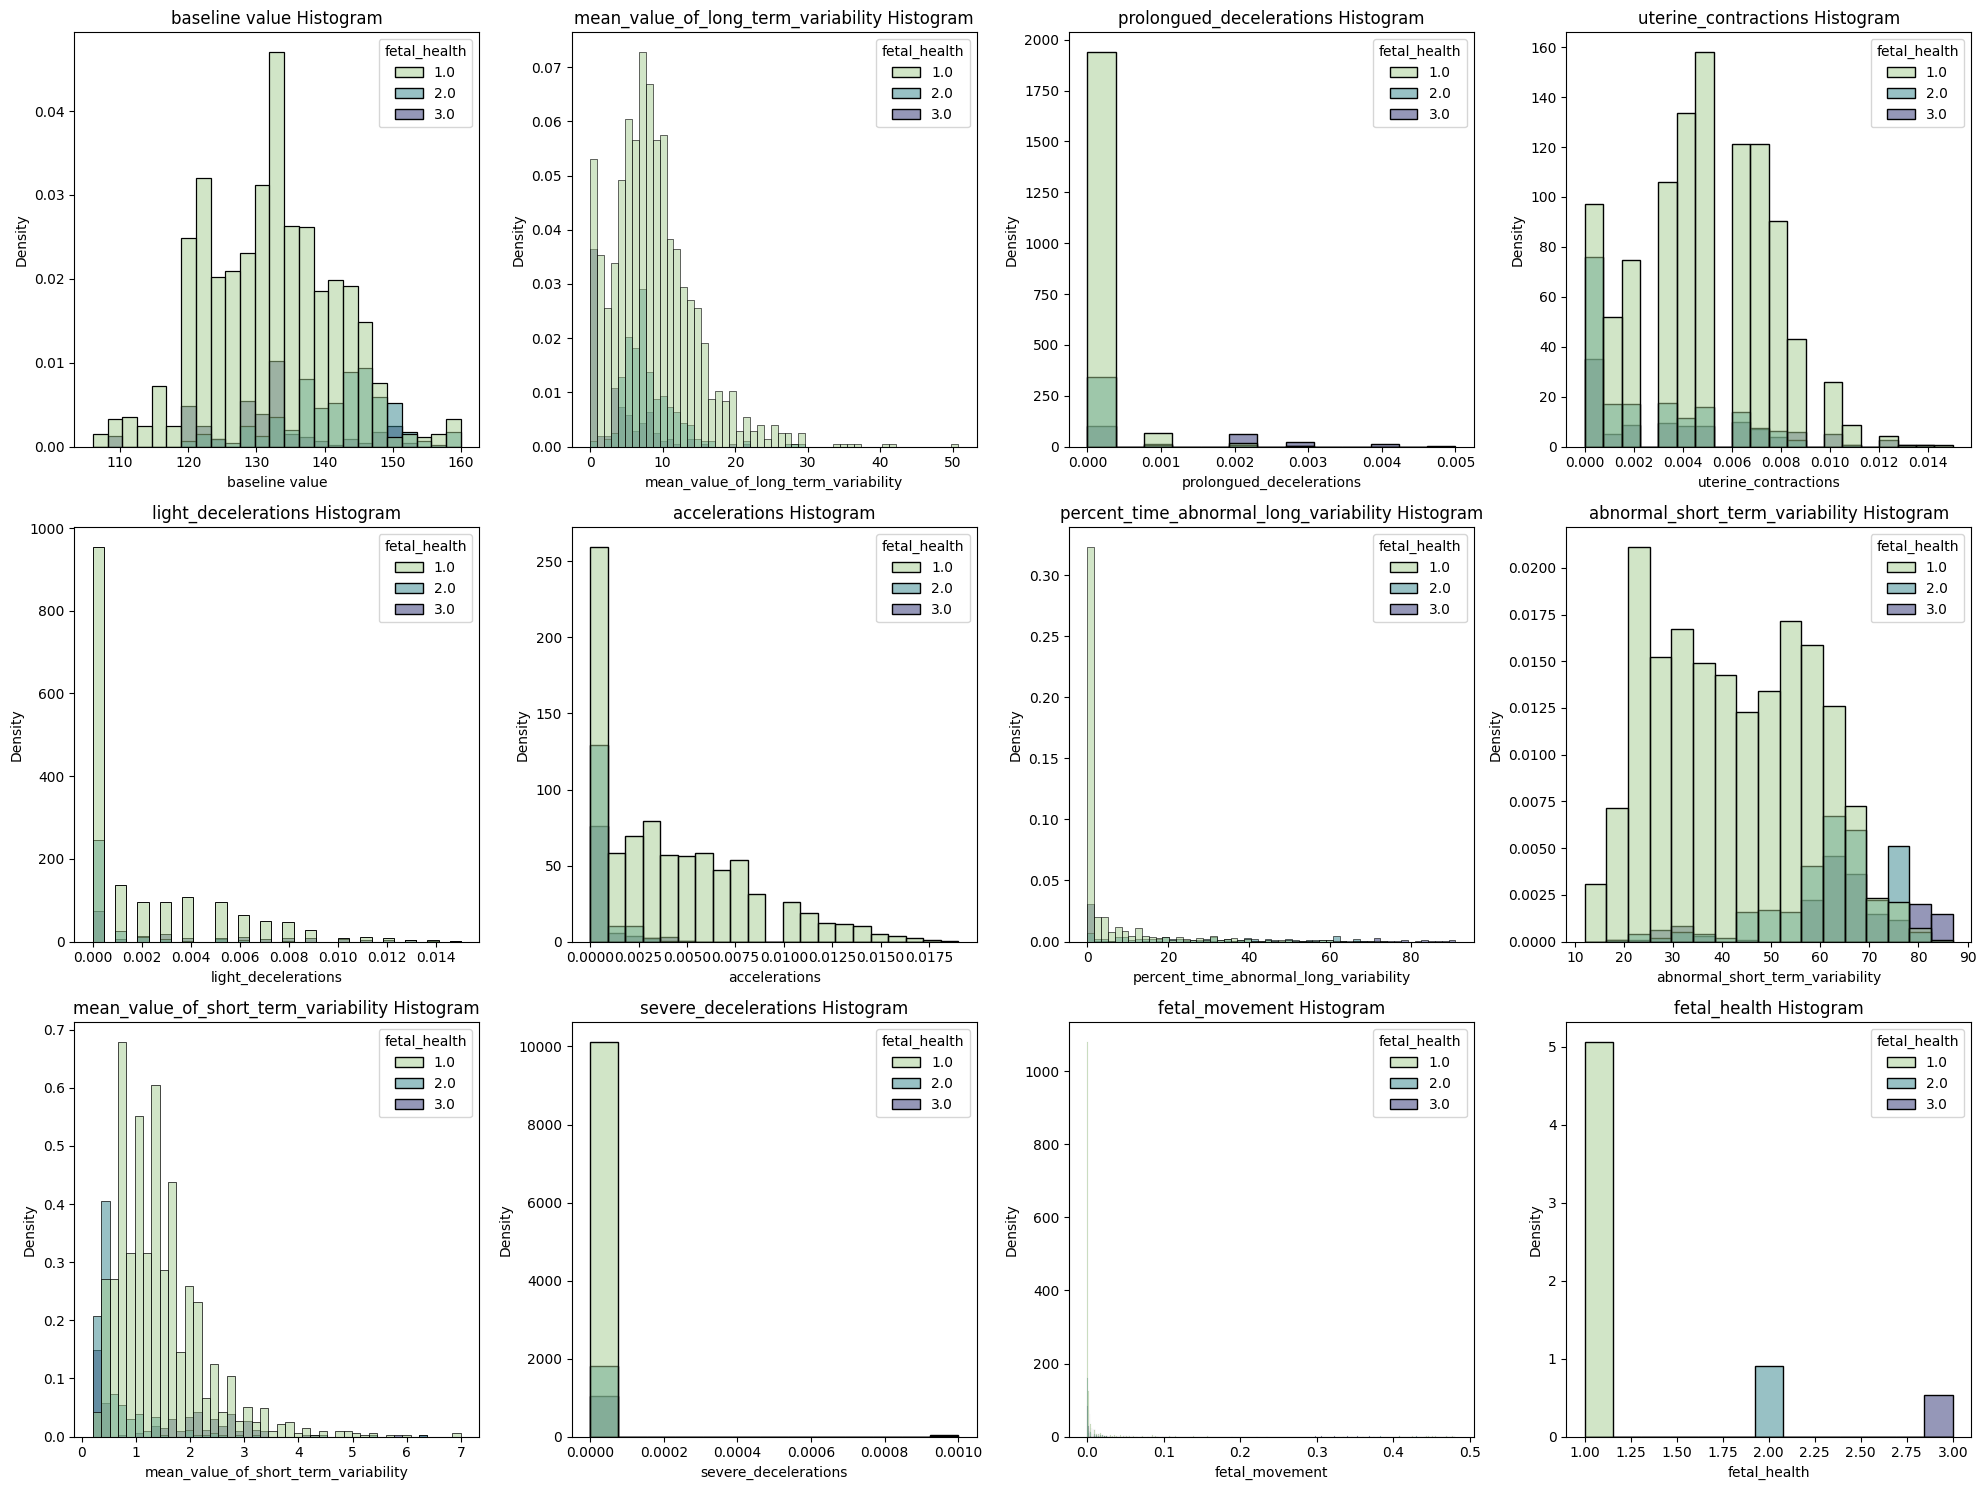

In [41]:
fig = plt.figure(figsize=(20,15))
axes = fig.subplots(3,4)
i = 0
j = 0
for col in feat[:-2]:
  sns.histplot(data=feat,
                x=feat[col], 
                hue=feat['fetal_health'],
                stat='density',
                palette='crest',
                ax=axes[i,j],)
  axes[i,j].set_title(f'{col} Histogram')
  i+=1
  j+=1
  if j == 4: j=0
  if i == 3: i=0
fig.tight_layout()
plt.show()

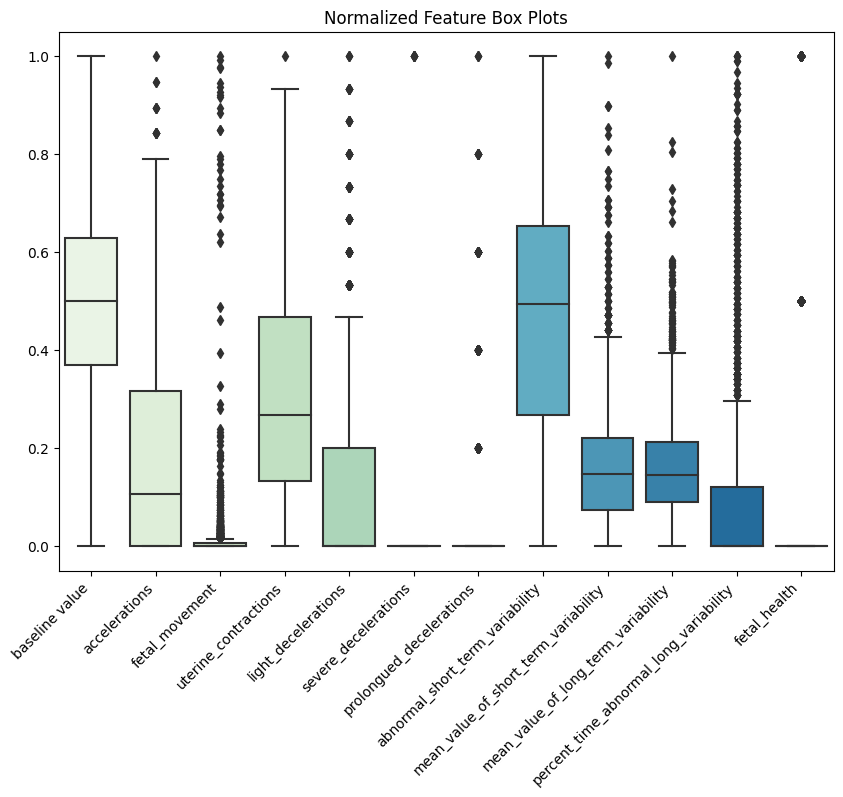

In [42]:
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler(feature_range=(0,1)).set_output(transform='pandas')
range_scaled = minmax.fit_transform(feat)
fig = plt.figure(figsize=(10,7))
sns.boxplot(range_scaled,
            palette='GnBu')
plt.title('Normalized Feature Box Plots')
plt.xticks(ha='right',rotation=45)
plt.show()

In [43]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [44]:
sc = StandardScaler().set_output(transform='pandas')
X_temp = feat.iloc[:, :-1]
X = sc.fit(X_temp).transform(X_temp).values
y = feat.iloc[:, -1].values
sss = StratifiedShuffleSplit(n_splits=2, 
                           train_size=0.8, 
                           test_size=0.2, 
                           random_state=1234)

for i, (train_index, test_index) in enumerate(sss.split(X, y)):
  X_train = X[train_index]
  y_train = y[train_index]

  X_test = X[test_index]
  y_test = y[test_index]
print(X_train.shape)

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test) # for ROC curves

(1700, 11)


In [45]:
def plot_split_results(data, param_dict, model_name):
  data = data.drop(columns=['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
                            'mean_test_score', 'std_test_score', 'std_train_score',
                            'rank_test_score', 'split0_train_score', 'split1_train_score',
                            'split2_train_score', 'split3_train_score', 'split4_train_score',
                            'split5_train_score', 'split6_train_score', 'split7_train_score',
                            'split8_train_score', 'split9_train_score', 'mean_train_score',])
  
  fig = plt.figure(figsize=(15,5))
  axes = fig.subplots(1, len(param_dict), sharey=True) 
  
  for i, (param_name, param_range) in enumerate(param_dict.items()):
    fig.suptitle(f'10-Fold Cross-Validation Results for {model_name} Hyper-Parameters', fontsize=15)
    grouped = data.groupby(by=f'param_{param_name}').agg('mean').T
    grouped.index = np.arange(1, len(grouped) + 1)

    sns.lineplot(grouped, palette='ocean', ax=axes[i])
    axes[i].set(title=param_name, 
                xlabel='Fold', 
                ylabel='Score', 
                visible=True)
    axes[i].set_xticks(grouped.index)
    axes[i].legend()
  plt.show()

In [46]:
def plot_ROC_curve(mod, XX_train, yy_train, XX_test):
  fig = plt.figure(figsize=(15,5))
  axes=fig.subplots(1,2)
  ConfusionMatrixDisplay.from_predictions(y_true=y_test, 
                                          y_pred=pred,
                                          cmap='GnBu', 
                                          ax=axes[0])
  axes[0].set(title=f'{model_names[i]} Confusion Matrix')
  try:
    y_score = mod.fit(XX_train, yy_train).predict_proba(XX_test)
  except:
    m = CalibratedClassifierCV(mod) 
    m.fit(XX_train, yy_train)
    y_score = m.predict_proba(XX_test)

  print(classification_report(y_test, pred))
  RocCurveDisplay.from_predictions(y_onehot_test.ravel(),
                                    y_score.ravel(),
                                    name="Micro-Average One-vs-Rest",
                                    color="navy",
                                    ax=axes[1])
  axes[1].set(title=f'{model_names[i]} ROC Curve', xlabel='False Positive Rate', ylabel='True Positive Rate')
  axes[1].plot([0, 1], [0, 1], label="chance level (AUC = 0.5)", color='lightgreen', linestyle='--')
  plt.legend()
  plt.show()


In [47]:
def plot_decision_boundary(mod):
  X_train_corr = X_temp[['abnormal_short_term_variability', 'percent_time_abnormal_long_variability']]

  mod.fit(X_train_corr, y)

  disp = DecisionBoundaryDisplay.from_estimator(mod,
                                                X_train_corr,
                                                response_method="predict",
                                                alpha=0.5,
                                                xlabel='Abnormal Short Term Variability',
                                                ylabel='Percent Time Abnormal Long Variability',
                                                cmap='GnBu')

  decision_function = mod.decision_function(X_train_corr)
  support_vector_indices = np.where(np.abs(decision_function) <= 1 + 1e-15)[0]
  support_vectors = X_train_corr.values[support_vector_indices]

  scat = plt.scatter(X_train_corr.iloc[:, 0], 
                      X_train_corr.iloc[:, 1], 
                      c=y, 
                      edgecolors="k", 
                      cmap='GnBu')
  plt.title('Decision Boundaries for Linear Support Vector Machine')

  handles, labels = scat.legend_elements()
  labels = ['1.0 - Normal', '2.0 - Suspect', '3.0 - Pathological']
  plt.legend(handles=handles, labels=labels)

  plt.show()

In [48]:
model_names = ['Decision Tree',
              'Support Vector Machine',
              'Gradient Boost',
              'k-Nearest Neighbors',
              'Logistic Regression']

dt = DecisionTreeClassifier(class_weight='balanced')

svm = SVC(class_weight='balanced')

gb = GradientBoostingClassifier()

knn = KNeighborsClassifier()

logreg = LogisticRegression(class_weight='balanced')

models = [dt, svm, gb, knn, logreg]

In [49]:
dt_params = {'criterion':('gini', 'entropy', 'log_loss'),
             'max_features':('auto', 'sqrt', 'log2'),
             'splitter':('random', 'best')}

svm_params = {'C':(1.0, 1.25, 1.5, 1.75, 2.0),
              'kernel':('linear', 'rbf', 'poly', 'sigmoid'),
              'degree':(1,2,3,4,5)}

gb_params = {'criterion':('friedman_mse', 'squared_error'),
             'loss':('log_loss', 'deviance'),
             'n_estimators':(100, 150, 200, 250)}

knn_params = {'metric':('manhattan','euclidean','cosine'),
              'weights':('uniform', 'distance'),
              'n_neighbors':(3, 5, 7, 9)}

logreg_params = {'C':(1.0, 1.25, 1.5, 1.75, 2.0),
                 'penalty': ('l1', 'l2'), 
                 'solver': ['liblinear']}

param_grids = [dt_params, svm_params, gb_params, knn_params, logreg_params]

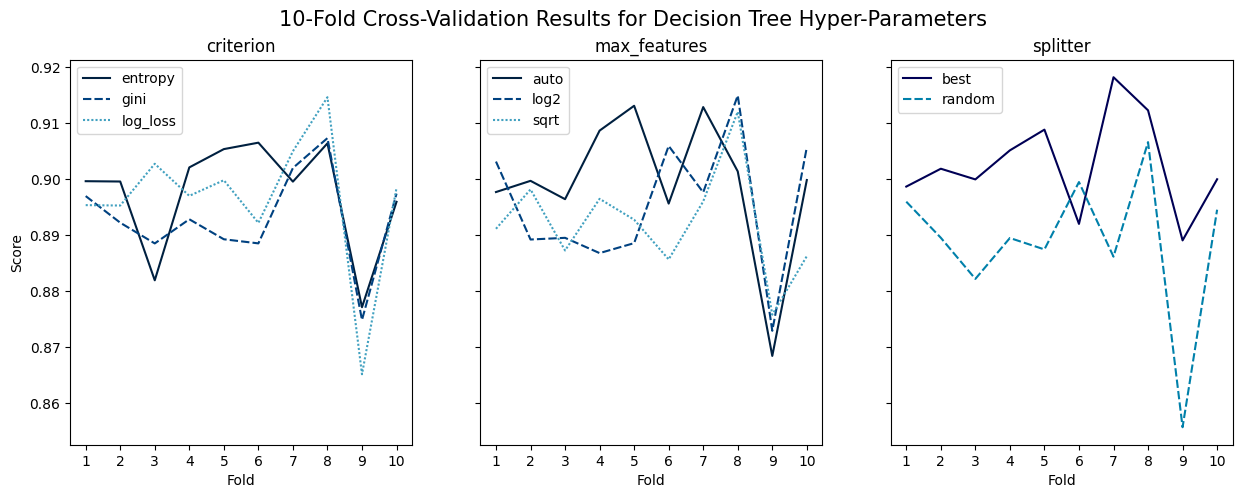


    -------  DecisionTreeClassifier  -------  
  The best estimator: DecisionTreeClassifier(class_weight='balanced', criterion='log_loss',
                       max_features='sqrt')
  The best score: 0.9125
  The best parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'splitter': 'best'}

              precision    recall  f1-score   support

         1.0       0.94      0.95      0.95       332
         2.0       0.71      0.69      0.70        59
         3.0       0.94      0.83      0.88        35

    accuracy                           0.91       426
   macro avg       0.86      0.83      0.84       426
weighted avg       0.91      0.91      0.91       426



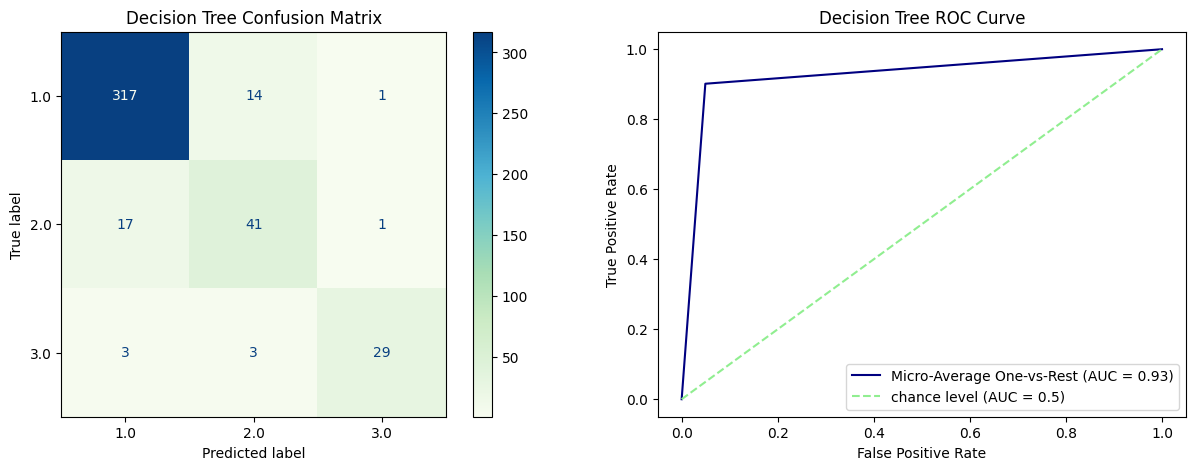

In [ ]:
for i in range(len(models)):
  grid = GridSearchCV(estimator=models[i], 
                      param_grid=param_grids[i],
                      scoring='f1_weighted',
                      return_train_score=True,
                      cv=10)
  grid.fit(X_train, y_train)
  results = pd.DataFrame(grid.cv_results_)#.loc[:,'params':'split9_test_score']
  plot_split_results(results, param_grids[i], model_names[i])

  print(f'\n    -------  {type(models[i]).__name__}  -------  ')
  print(f'  The best estimator: {grid.best_estimator_}')
  print(f'  The best score: {round(grid.best_score_, 4)}')
  print(f'  The best parameters: {grid.best_params_}\n')
  # display(results[['params', 'rank_test_score', 
  #                 'mean_test_score', 'std_test_score', 
  #                 'mean_train_score', 'std_train_score']])
  
  model = grid.best_estimator_
  pred = grid.predict(X_test)

  plot_ROC_curve(model, X_train, y_train, X_test)
  if model_names[i] == 'Support Vector Machine':
    plot_decision_boundary(model)